# ASSIGNMENT 2: TREND DETECTION

Lily Huang and Shreeshankar Chatterjee

## Table of Contents
* [Introduction](#one)
* [Environment setup](#two)
* [Data setup](#three)
* [Exploratory analysis](#four)
* [Topic modeling](#five)
    * [Bag of words: LSA](#a)
        * [Trending LSA topics (titles)](#a1)
        * [Trending synonym-constructed topics (titles)](#a2)
        * [Trending LSA topics (full text)](#a3)
    * [Bag of words: LDA](#b)
    * [Neural nets: word2vec](#c)
* [Final trend analysis](#six)

## <a class="anchor" id="one">Introduction </a>


In this project, we will examine NIPS papers from 1987-2017. 

Using unsupervised learning, we will try to discover "topics" given the title, authors, and body of the texts. To do this, we will go through three different approaches.

The first approach is a bag-of-words method with Latent Semantic Indexing. Out of the three, LSA yielded the most promising results. For this reason, we did a deeper exploration and found three separate ways to utilize the LSA. 

The second approach is another bag-of-words method with Latent Dirichlet Allocation. Despite thorough testing with various input datasets, and grid searching for optimal parameters, we were not able to get stable or meaningful results. Nonetheless, we have included the best attempt for the sake of comparison.

Finally, the last approach is through a neural networks angle, in which we will use word2vec to represent words and documents numerically, and thus allowing us to compare and contrast them. We clustered similar documents together and looked for trends that way. Due to the computational intensity of both building the model and calculating the word mover distance, this last approach had the least exploration, as we were restricted to the smallest input dataset possible. However, within the limited exploration, we found the results highly similar to that picked up by the LSA.

For all three approaches, after we identified the topics, we aggregated by year. Then, using the slope, we  found the top 10 and bottom 10 trending topics in the past 30 years. 

To skip to the final results, please go to the section "Final trend analysis".

Please note that to cut down on computation time, certain time-costly results were only run once then saved and reloaded into the notebook. As such, this notebook is dependent on external files to run to completion. They can be provided upon request.

## <a class="anchor" id="two">Environment setup</a>

In this section, we will set up our working environment.

In [1]:
# import utility libraries
import os
import glob
import sys
import pandas as pd
import numpy as np
from collections import Counter
from datetime import datetime
from time import time
import re
import operator

# import graphics
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

# import sklearn tools
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.preprocessing import Binarizer, Normalizer
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

# import nltk tools
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

# import gensim tools
from gensim import corpora, models 
from gensim.models.coherencemodel import CoherenceModel
from gensim.test.utils import common_corpus
from gensim.models import Word2Vec

# import mlxtend tools
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# import other nlp tools
import ast
import string
from pyemd import emd

In [2]:
# import stop words from english dictionary
## nltk.download('stopwords')
stop_words = set(stopwords.words("english"))

In [3]:
# set working directory
os.chdir("/Users/lily/Downloads/CSCI82/")

## <a class="anchor" id="three">Data setup</a> 

In this section, we will be importing and merging the data. The data has been pre-downloaded from https://www.kaggle.com/benhamner/nips-papers.

In [4]:
# import data
data_authors = pd.read_csv("authors.csv")
data_crosswalk = pd.read_csv("paper_authors.csv")
data_papers = pd.read_csv("papers.csv")

In [5]:
# merge author name into crosswalk
data_crosswalk = data_crosswalk.merge(data_authors,
                                       how="left",
                                       left_on="author_id",
                                       right_on="id")
data_crosswalk = data_crosswalk[["paper_id", "name"]]

In [6]:
# create dictionary of all authors for each paper
paper_author_dict = {}
for paper_id in np.unique(data_crosswalk[["paper_id"]].values):
    authors = data_crosswalk[data_crosswalk["paper_id"] == paper_id].iloc[:,1].values
    paper_author_dict[paper_id] = set(authors)

In [7]:
# add authors into final dataset
data = data_papers.copy()
data["authors"] = data["id"].map(paper_author_dict)
data = data[["year", "title", "authors"]]

With the above, we have now the year, title, and authors of every paper. We will also include the text. However, because of the large text size of each paper, we ran the body text separately for analysis. After some data exploration, we parsed out and kept only words belonging to approximately 10000 of the top one-grams. We also included the top 100 bigrams for each paper. In the interest of saving computational time, we will upload the results into the notebook instead of regenerating every time.

In [8]:
data = pd.read_pickle("final_data.pkl")
data.head()

year                                              title  \
0  1987  Self-Organization of Associative Database and ...   
1  1987  A Mean Field Theory of Layer IV of Visual Cort...   
2  1988  Storing Covariance by the Associative Long-Ter...   
3  1994  Bayesian Query Construction for Neural Network...   
4  1994  Neural Network Ensembles, Cross Validation, an...   

                                      authors  \
0            {Hisashi Suzuki, Suguru Arimoto}   
1                   {Christopher L. Scofield}   
2  {Patric K. Stanton, Terrence J. Sejnowski}   
3            {Gerhard Paass, J?rg Kindermann}   
4             {Jesper Vedelsby, Anders Krogh}   

                                       text_onegrams  \
0  [associ, cost, empti, faith, section, machin, ...   
1  [constraint, spite, tune, asymptot, similar, r...   
2  [enhanc, constraint, associ, depress, research...   
3  [constraint, seen, cost, section, asymptot, si...   
4  [constraint, want, agre, poor, stack, machin, ...   

                                    text_top_bigrams  
0  ['self organ', 'observ sampl', 'recognit rate'...  
1  ['mean field', 'cortic cell', 'mean field appr...  
2  ['synapt strength', 'long term', 'pyramid neur...  
3  ['squar loss', 'input distribut', 'mont carlo ...  
4  ['general error', 'cross valid', 'optim weight...

Our final dataset has four variables: year, title, authors, text_onegrams, and text_top_bigrams. There are 7241 observations.

## <a class="anchor" id="four">Exploratory analysis</a> 

In this section, we will perform some exploratory data analysis to understand the data better.

### Number of publications per year

First, we will examine the number of papers that are published each year.

In [9]:
# get count of papers per year
papers_per_year = data.copy()
papers_per_year["count"] = np.ones(papers_per_year.shape[0])
papers_per_year = papers_per_year[["year", "count"]].copy()
papers_per_year = papers_per_year.groupby('year').agg(['sum'])

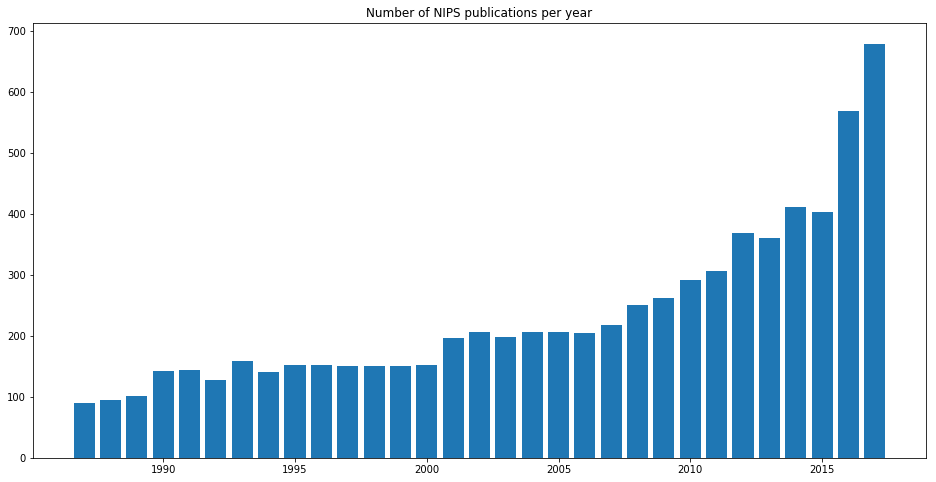

In [10]:
# plot number of papers per year
plt.rcParams['figure.figsize'] = [16, 8]
plt.bar(papers_per_year.index.values, papers_per_year.iloc[:,0].values)
plt.title("Number of NIPS publications per year")
plt.show()

As expected, the number of papers have been increasing over time, meaning later years will have a higher representation of words and topics. Because of this, we will be applying a normalization in our later charts, so that a word or topic is weighted relative to each particular year.

### Frequency of words

Next, we will look at the frequency of words and the size of our overall corpus. Words are processed and cleaned, with captalization and punctuation removed. Stop words are also removed. Finally, the words are stemmed with the Snowball stemmer (also known as the Porter 2), which is an improved and slightly more aggressive version of the commonly used Porter stemmer.

In [11]:
# create custom tokenizer that includes stemmer
def custom_tokenize(text):
    tokenizer = RegexpTokenizer(r'\w+')
    stemmer = SnowballStemmer('english')
    tokens = tokenizer.tokenize(text) 
    tokens = [stemmer.stem(w) for w in tokens]
    tokens = [token for token in tokens if not token in stop_words]
    return tokens

# turn bodies of text into word count vectors
def get_word_count(vectorizer, text):
    count = vectorizer.fit_transform(text)
    count = pd.DataFrame(count.toarray())
    count.columns = vectorizer.get_feature_names()
    return count

# get the top words across all observations
def get_top_words(count, n_top):
    total_count = np.sum(count, axis=0)
    sorted_index = np.flip(np.argsort(total_count), axis=0)
    sorted_index = np.array(sorted_index[0:n_top])
    top_words = np.array(count.columns)[sorted_index]
    top_words_count = np.array(total_count)[sorted_index]
    return top_words, top_words_count

In [12]:
# create vectorizers that converts text to ngrams
get_onegrams = CountVectorizer(stop_words='english',
                                   tokenizer=custom_tokenize,
                                   ngram_range=(1, 1))
get_twograms = CountVectorizer(stop_words='english',
                                   tokenizer=custom_tokenize,
                                   ngram_range=(2, 2))

In [13]:
# get all one and two grams of titles
titles_onegram = get_word_count(get_onegrams, data["title"])
titles_twogram = get_word_count(get_twograms, data["title"])

In [14]:
# get all one and two grams of text
#text_onegram = get_word_count(get_onegrams, data["paper_text"])
#text_twogram = get_word_count(get_twograms, data["paper_text"])

In [15]:
print("Number of 1-grams across titles: ", titles_onegram.shape[1])
print("Number of 2-grams across titles: ", titles_twogram.shape[1])

Number of 1-grams across titles:  3732
Number of 2-grams across titles:  24640


We can see in titles alone, there are approximately 3,700 words and 24,600 two-word phrases.

### Top words in titles

Let us examine which are the most common words in titles.

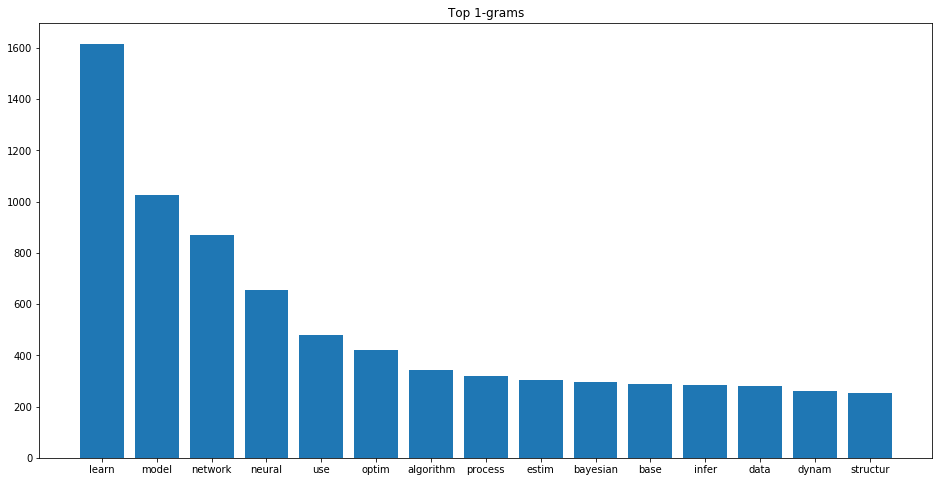

In [16]:
# get top words
top_words, top_wc = get_top_words(titles_onegram, n_top=15)

# plot top words
fig, ax = plt.subplots(figsize=(16, 8))
plt.bar(top_words,top_wc)
plt.title("Top 1-grams")
plt.show()

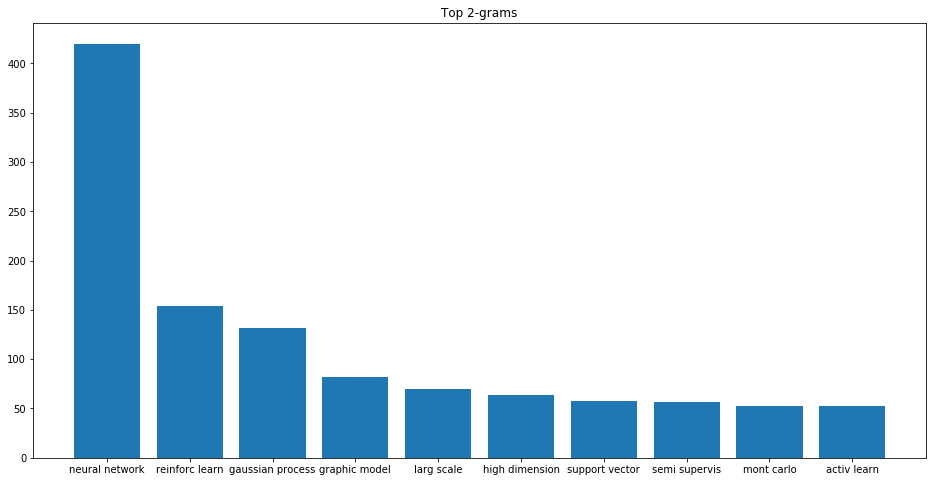

In [17]:
# top 2-word phrases
top_words, top_wc = get_top_words(titles_twogram, n_top=10)

# plot top 2-word phrases
fig, ax = plt.subplots(figsize=(16, 8))
plt.bar(top_words,top_wc)
plt.title("Top 2-grams")
plt.show()

We can see obvious overlap between the 1-gram and 2-gram. There are clear compound words that need to be noted.

### Trending words/phrases in titles

Now we will do a very basic approach of treating each word as its own concept and plotting the percent growth, across all years, of their yearly weight/consitution.

In [18]:
# retrieve all the words with a significant count
total_count = np.sum(titles_onegram, axis=0)
sig_words = total_count[total_count > 10].index.values

In [19]:
# aggregate all the word counts by year
titles_agg = titles_onegram.copy()
titles_agg["year"] = data["year"]
titles_agg = titles_agg.groupby("year").agg(["sum"])
titles_agg = titles_agg[sig_words]
titles_agg.columns = sig_words

In [20]:
# given dataframe, pre-aggregated by year, get top 10 and bottom 10 features 
def get_top_bottom(agg_df):
    
    # get distribution of words for each year
    agg_df_norm = agg_df.divide(agg_df.sum(axis=1), axis=0)
    
    # get slope / trend line
    slopes = agg_df_norm.apply(lambda x: np.polyfit(agg_df_norm.index, x, 1)[0])
    trending = slopes.index.values[np.argsort(slopes)]
    
    # get top and bottom 10
    bottom_10 = agg_df_norm[trending[:10]] + 1
    top_10 = agg_df_norm[np.flip(trending, axis=0)[:10]] + 1
    bottom_10 = bottom_10.divide(bottom_10.iloc[-1, :] / 100)
    top_10 = top_10.divide(top_10.iloc[0, :] / 100)
    
    return top_10, bottom_10, np.flip(np.argsort(slopes), axis=0)[:10], np.argsort(slopes)[:10]

In [21]:
# get top 10 and bottom 10 trends
top_10, bottom_10, ti, bi = get_top_bottom(titles_agg)

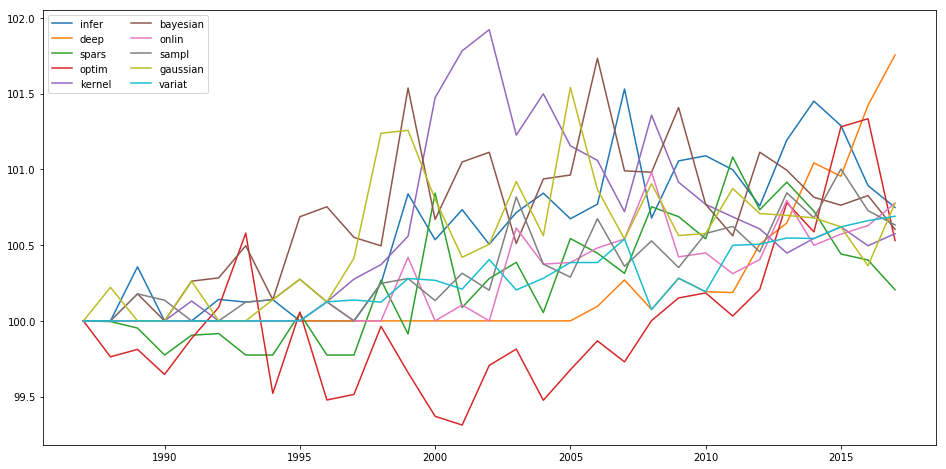

In [22]:
# plot top 10
fig,ax = plt.subplots()

for f in (top_10.columns):
    ax.plot(top_10.index.values, top_10[f], label=f)
    
ax.legend(loc='upper left', ncol=2)

From initial glance, we can see infer(ence) and deep are currently the highest trending words in paper titles.

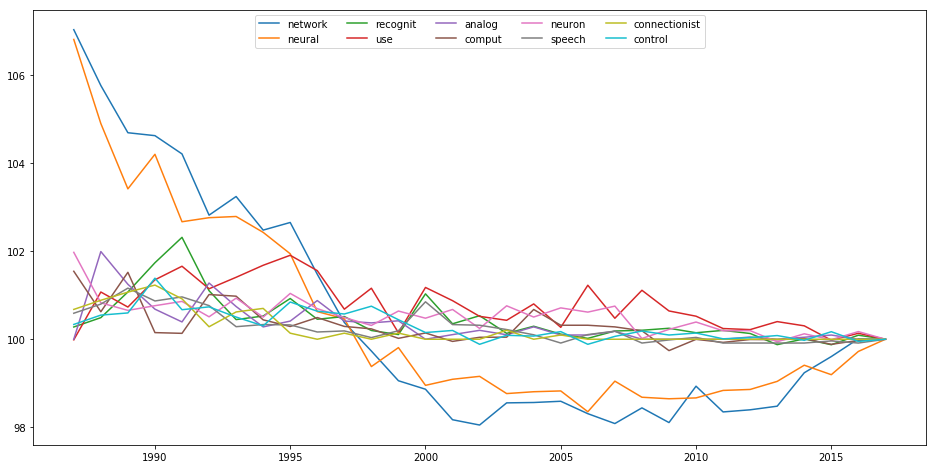

In [23]:
# plot bottom 10
fig,ax = plt.subplots()

for f in (bottom_10.columns):
    ax.plot(bottom_10.index.values, bottom_10[f], label=f)
    
ax.legend(loc='upper center', ncol=5)

Meanwhile, neural and network have had the most proportional decline in the past 30 years.

## <a class="anchor" id="five">Topic Modelling</a>

With our initial exploration done, we will now try to capture concepts instead of just single words. Concepts, or "topics", here can be thought as an aggregate expression of many different words in different combinations. It is our hope that these topics end up capturing groups of synonyms or words often within the same field or subject. In the process of doing so, we hope to gain a clearer picture of what these fields or subjects may be within this domain.

### Bag of words representation

Two of the techniques we will use, LSA and LDA, use a bag-of-words method. As such, ordering and context do not matter, and we can combining our data together. We will prepare two sets of data to feed into our model: one includes only the title and author (broad) and one includes the title, author, and text (fine).

In [24]:
# append authors to titles
authors_list = []
author_titles = []
for i in range(data.shape[0]):
    authors = data["authors"][i]
    if type(authors) == float:
        authors = ""
    else:
        authors = [re.sub('[^A-Za-z0-9]+', '', a) for a in authors]
    authors = " ".join(authors)
    authors_list.append(authors)
    author_titles.append(authors + 
                         " " + data["title"][i]) 

In [25]:
# append text to authors and titles
author_titles_tokens = [custom_tokenize(a) for a in author_titles]
full_tokens = [author_titles_tokens[i] + data["text_onegrams"][i] for i in range(data.shape[0])]
full_strings = [" ".join(token) for token in full_tokens]

In [26]:
# get all one and two grams of authors and titles
get_onetwograms = CountVectorizer(stop_words='english',
                                  tokenizer=custom_tokenize,
                                  ngram_range=(1,2),
                                  max_features=5000)
author_titles_count = get_word_count(get_onetwograms, author_titles)
#full_count = get_word_count(get_onetwograms, full_strings)
full_count = pd.read_pickle("full_count.pkl")

# get all words in total corpus for authors and titles
all_words_total = full_count.columns

### Normalization with TF-IDF

LSA in particular can benefit from normalization by TF-IDF. Term Frequency Inverse Document Frequency is a technique used to re-weigh words by relative importance. We can also use it to extract the most important words.

In [27]:
# create vectorizers that converts text to weighted ngrams
get_tfidf = TfidfVectorizer(
    tokenizer=custom_tokenize,
    stop_words='english',
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w+',
    ngram_range=(1,2),
    max_features=5000)

# get all weighted one and two grams of titles
author_titles_tfidf = get_word_count(get_tfidf, author_titles)

# get all words in tf-idf corpus
all_words = author_titles_tfidf.columns

In [28]:
# get set of authors
authors_list1 = set(get_word_count(get_tfidf, authors_list).columns)
authors_list1 = list(authors_list1)
authors_list1.sort()

# get word importance, including and excluding authors
word_importance = np.sum(author_titles_tfidf, axis=0)
word_importance1 = [word_importance[word] if word not in authors_list1 else 999 for word in word_importance.index]

# get most important words
important_words = np.flip(np.argsort(word_importance).values, axis=0)

We now have weights on the relative importance of each word for every document.

## <a class="anchor" id="a">Latent Semantic Analysis</a>

In this section, we will use the technique of Latent Semantic Analysis to represent each document as a vector of features. Each feature is then a linear combination of the ngrams in the corpus.

For LSA, we will approach topic modelling from three different angles. The first is look at the LSA topics themselves, as constructed from looking at only the authors and titles of papers, and map those with respect to time. The second is to construct topics from the term-matrix given by LSA by clustering similar terms together, then mapping those constructed topics with respect to time. Finally, we will repeat the above, except now taking into account the body text of the paper as well.

### LSA model given titles and authors

In building our model, we will go with the recommendation in the TruncatedSVD documentation and choose 100 topics.

In [41]:
# build lsa model and extract relevant matrices
lsa_model = TruncatedSVD(n_components=100)
lsa_doc_matrix = lsa_model.fit_transform(author_titles_tfidf)
lsa_term_matrix = lsa_model.components_
lsa_topic_matrix = np.diag(lsa_model.singular_values_)

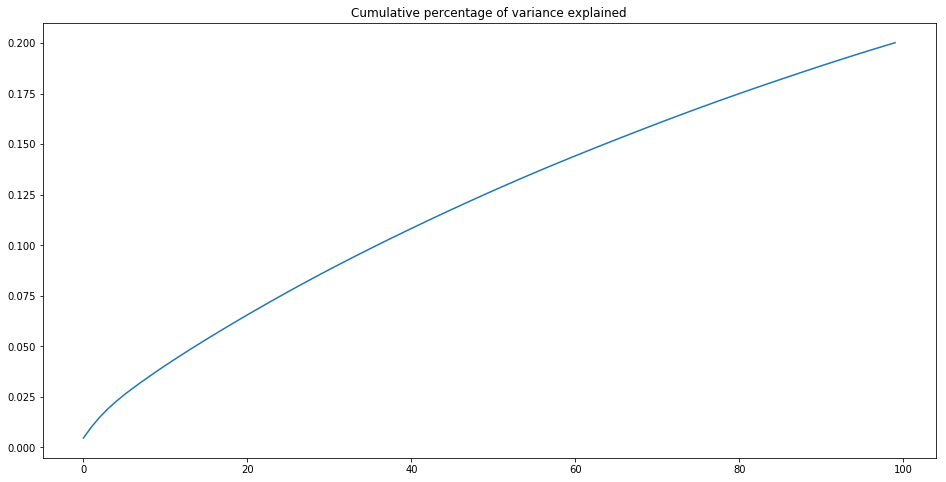

In [42]:
# plot variance explained
explained_var = np.cumsum(lsa_model.explained_variance_ratio_)
plt.plot(explained_var)
plt.title("Cumulative percentage of variance explained")
plt.show()

Plotting our variance, we can see that approximately one-fifth of the information is captured in our new features. 

Next, we will try to find what topic each document primarily belongs to, as well as find what words belong to each topic.

In [43]:
# for each document, get the highest topic
def get_keys(doc_matrix):
    keys = [doc_matrix[i].argmax() for i in range(doc_matrix.shape[0])]
    return keys

# count the number of documents that has topic  
def keys_to_counts(keys):
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

# get words that constitute each topic in order of importance
def get_words_for_topic(term_matrix, all_words):
    words_for_topic = {}
    for i in range(term_matrix.shape[0]):
        ordered_index = np.flip(np.argsort(term_matrix[i, :]), axis=0)
        words_for_topic[i] = list(all_words[ordered_index])
    return words_for_topic

In [44]:
# get counts of how many documents belong to each topic
lsa_keys = get_keys(lsa_doc_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [45]:
# generate dictionary mapping topic id to primary words
words_in_topic = get_words_for_topic(lsa_term_matrix, author_titles_tfidf.columns)
topic_names = {}
for key, value in words_in_topic.items():
    topic_names[str(key)] = "-".join(value[:3])

In [46]:
# examine words within the top topics
n_top_topics = 10
n_words_per_topic = 5
top_topics = np.array(lsa_categories)[np.flip(np.argsort(lsa_counts), axis=0)]
for i in top_topics[:n_top_topics]:
    topics = ", ".join(words_in_topic[i][:n_words_per_topic])
    print("Topic {}: ".format(i), topics)

Topic 0:  network, neural, neural network, learn, model
Topic 2:  learn, reinforc, reinforc learn, deep, supervis
Topic 8:  bayesian, infer, dynam, variat, neuron
Topic 3:  process, gaussian, gaussian process, learn, regress
Topic 7:  use, recognit, reinforc, reinforc learn, dynam
Topic 12:  cluster, supervis, data, estim, optim
Topic 30:  data, time, classif, deep, imag
Topic 41:  distribut, represent, inform, activ, linear
Topic 23:  kernel, featur, select, supervis, random
Topic 10:  analysi, dynam, compon, compon analysi, neuron


From a glance, it would appear the LSA has managed to create topics around similar words and subjects.

### <a class="anchor" id="a1">Trending LSA topics</a> 

Given our new topics constructed from titles and authors, now let's see which ones are trending.

In [47]:
# get yearly aggregates
lsa_data = pd.DataFrame(lsa_doc_matrix)
lsa_data[lsa_data < 0] = 0
lsa_data["year"] = data["year"]
lsa_data = lsa_data.groupby(["year"]).agg(["sum"])
lsa_data.columns = [str(i) for i in list(range(100))]

In [48]:
# get top 10 and bottom 10 trends
top_10, bottom_10, ti, bi = get_top_bottom(lsa_data)
bottom_10 = bottom_10.rename(index=str, columns=topic_names)
top_10 = top_10.rename(index=str, columns=topic_names)

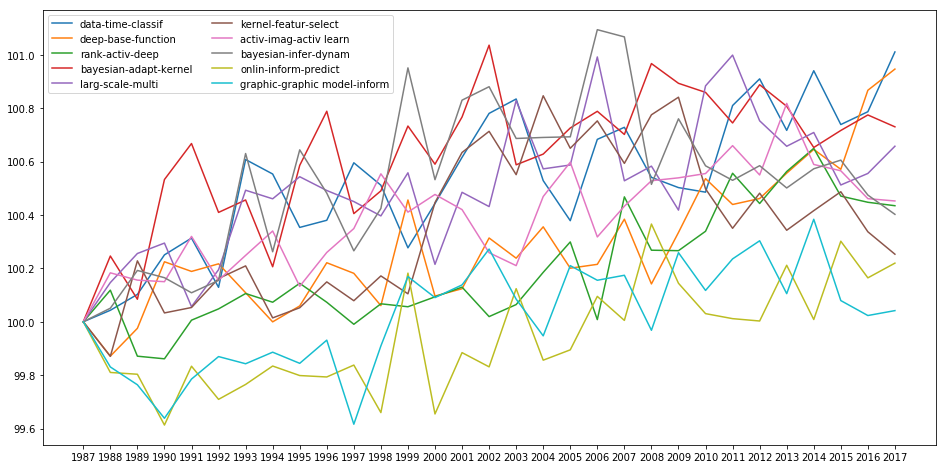

In [49]:
# plot top 10
fig,ax = plt.subplots()

for f in (top_10.columns):
    ax.plot(top_10.index.values, top_10[f], label=f)
    
ax.legend(loc='upper left', ncol=2)

In [50]:
n_words_per_topic = 8
for i in ti:
    topics = ", ".join(words_in_topic[i][:n_words_per_topic])
    print("Topic {}: ".format(i), topics)

Topic 30:  data, time, classif, deep, imag, base, gradient, rank
Topic 21:  deep, base, function, structur, estim, adapt, markov, inform
Topic 35:  rank, activ, deep, matrix, mont, carlo, mont carlo, low
Topic 17:  bayesian, adapt, kernel, multi, estim, classif, gradient, sampl
Topic 14:  larg, scale, multi, larg scale, dynam, cluster, data, predict
Topic 23:  kernel, featur, select, supervis, random, semi, semi supervis, regress
Topic 45:  activ, imag, activ learn, algorithm, graphic, kernel, graphic model, adapt
Topic 8:  bayesian, infer, dynam, variat, neuron, variat infer, spike, time
Topic 42:  onlin, inform, predict, dimension, regress, onlin learn, approach, bandit
Topic 33:  graphic, graphic model, inform, dynam, carlo, mont, mont carlo, spars


Most of these topics are human interpretable. It would appear our top trending topics include real time image classification and bayesian classification.

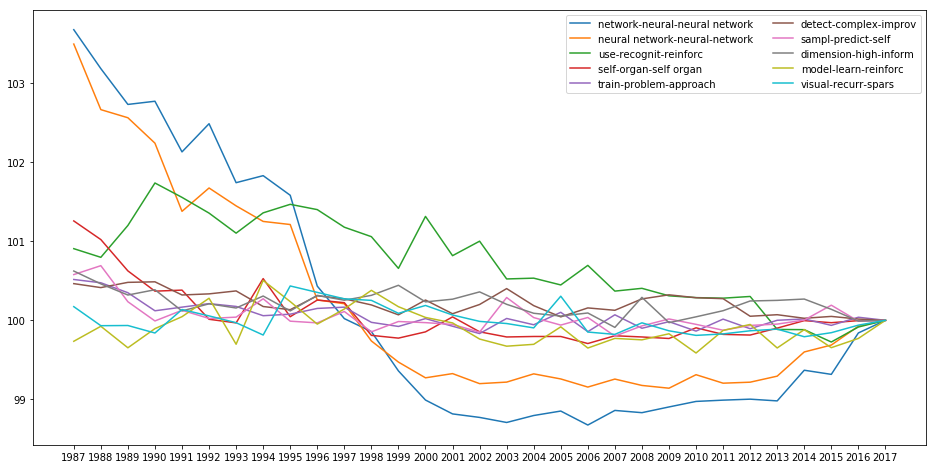

In [51]:
# plot bottom 10
fig,ax = plt.subplots()

for f in (bottom_10.columns):
    ax.plot(bottom_10.index.values, bottom_10[f], label=f)
    
ax.legend(loc='upper right', ncol=2)

In [52]:
n_words_per_topic = 8
for i in bi:
    topics = ", ".join(words_in_topic[i][:n_words_per_topic])
    print("Topic {}: ".format(i), topics)

Topic 0:  network, neural, neural network, learn, model, use, dynam, optim
Topic 1:  neural network, neural, network, recurr, recurr neural, convolut neural, convolut, deep neural
Topic 7:  use, recognit, reinforc, reinforc learn, dynam, neuron, speech, time
Topic 47:  self, organ, self organ, general, map, memori, associ, activ
Topic 75:  train, problem, approach, non, control, generat, matrix, classifi
Topic 81:  detect, complex, improv, classifi, problem, label, non, space
Topic 48:  sampl, predict, self, linear, organ, method, self organ, map
Topic 43:  dimension, high, inform, high dimension, classif, mixtur, matrix, rank
Topic 4:  model, learn, reinforc, reinforc learn, graphic, graphic model, process, gaussian
Topic 46:  visual, recurr, spars, approach, attent, human, recurr neural, approxim


It would appear our least trending topics include neural networks, speech recognition, and self-organization.

### Word similarities and synonyms

The decomposition from LSA also provides us with a term matrix that we can use to examine word similarities.

In [53]:
top_important_words = important_words[:100]
word_similarities = cosine_similarity(lsa_term_matrix.transpose()[top_important_words].dot(lsa_topic_matrix))

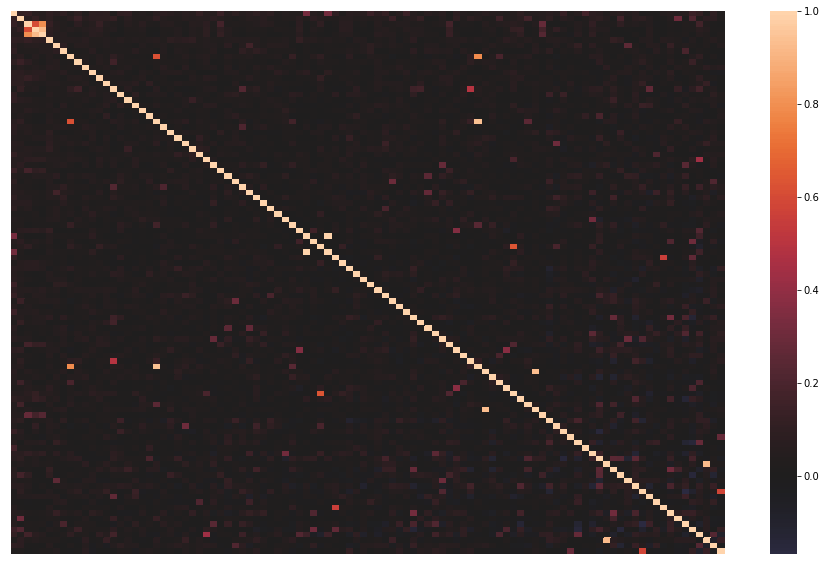

In [54]:
fig, ax = plt.subplots(figsize=(16, 10))
ax = sns.heatmap(word_similarities, center=0, yticklabels=False, xticklabels=False)

Furthermore, we can find the top words that are the most similar to one another.

In [55]:
synomym_pairs = np.where(np.logical_and(word_similarities < 0.99, word_similarities > 0.5))
for i in range(len(synomym_pairs[0])):
    if synomym_pairs[0][i] < synomym_pairs[1][i]:
        word1 = all_words[top_important_words[synomym_pairs[0][i]]]
        word2 = all_words[top_important_words[synomym_pairs[1][i]]]
        print(", ".join([word1, word2]))

network, neural
network, neural network
neural, neural network
process, gaussian
process, gaussian process
gaussian, gaussian process
neuron, spike
machin, vector
larg, scale
dimension, high
factor, matrix


So we can see LSA actually implicitly helps us with the compound words problem, as it assign them similar vectors. Given this information, we can try to cluster words together and create our own refined topics. To help determine the right number of clusters, we chose based off the best silhouette.

In [56]:
word_similarities = cosine_similarity(lsa_term_matrix.transpose().dot(lsa_topic_matrix))
word_distances = (2 * (1 - word_similarities))
word_distances[word_distances < 0] = 0
word_distances = np.sqrt(word_distances)

In [57]:
clustering = AgglomerativeClustering(n_clusters=400, affinity="precomputed", linkage="average")
cluster_labels = clustering.fit_predict(word_distances)

In [58]:
#for i in np.floor(np.power(list(range(2, 50)), 2)):
#    clustering = AgglomerativeClustering(n_clusters=int(i), affinity="precomputed", linkage="average")
#    cluster_labels = clustering.fit_predict(word_distances)
#    print(i, ":", silhouette_score(word_distances, labels=cluster_labels, metric="precomputed"))

In [59]:
author_titles_tfidf_syn = author_titles_tfidf.copy().transpose()
author_titles_tfidf_syn["word_type"] = cluster_labels
author_titles_tfidf_syn = author_titles_tfidf_syn.groupby("word_type").agg("sum").transpose()

In [60]:
lsa_syn_dict = {}
for i in set(cluster_labels):
    words_index = np.where(cluster_labels == i)[0]
    importance = np.array(word_importance1)[words_index]
    words_importance_order = np.argsort(importance)
    lsa_syn_dict[i] = all_words[words_index[words_importance_order]]

In [61]:
lsa_syn_labels = {}
for i in set(cluster_labels):
    lsa_syn_labels[str(i)] = "-".join(lsa_syn_dict[i][:6])

### <a class="anchor" id="a2">Trending synonym-constructed LSA topics</a>

In this section, we will use our own synonym-constructed topics to look for trends.

In [62]:
lsa_data = author_titles_tfidf_syn
lsa_data[lsa_data < 0] = 0
lsa_data["year"] = data["year"]
lsa_data = lsa_data.groupby(["year"]).agg(["sum"])
lsa_data.columns = [str(i) for i in range(lsa_data.shape[1])]

In [63]:
# get top 10 and bottom 10 trends
top_10, bottom_10, ti, bi = get_top_bottom(lsa_data)
bottom_10 = bottom_10.rename(index=str, columns=lsa_syn_labels)
top_10 = top_10.rename(index=str, columns=lsa_syn_labels)

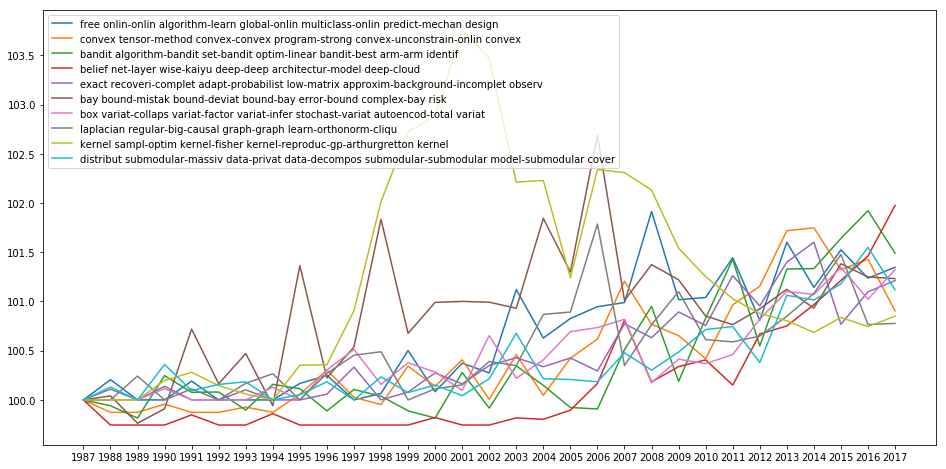

In [64]:
# plot top 10
fig,ax = plt.subplots()

for f in (top_10.columns):
    ax.plot(top_10.index.values, top_10[f], label=f)
    
ax.legend(loc='upper left', ncol=1)

In [65]:
n_words_per_topic = 6
for i in ti:
    topics = ", ".join(lsa_syn_dict[i][:n_words_per_topic])
    print("Topic {}: ".format(i), topics)

Topic 56:  free onlin, onlin algorithm, learn global, onlin multiclass, onlin predict, mechan design
Topic 8:  convex tensor, method convex, convex program, strong convex, unconstrain, onlin convex
Topic 93:  bandit algorithm, bandit set, bandit optim, linear bandit, best arm, arm identif
Topic 64:  belief net, layer wise, kaiyu deep, deep architectur, model deep, cloud
Topic 27:  exact recoveri, complet adapt, probabilist low, matrix approxim, background, incomplet observ
Topic 33:  bay bound, mistak bound, deviat bound, bay error, bound complex, bay risk
Topic 254:  box variat, collaps variat, factor variat, infer stochast, variat autoencod, total variat
Topic 232:  laplacian regular, big, causal graph, graph learn, orthonorm, cliqu
Topic 94:  kernel sampl, optim kernel, fisher kernel, reproduc, gp, arthurgretton kernel
Topic 144:  distribut submodular, massiv data, privat data, decompos submodular, submodular model, submodular cover


The topics remain extremely human interpretable. Furthermore, our topics have become more refine and precise. From the LSA topics, tensor/non-convex methods, the bandit problem, and online learning appear to be top trends.

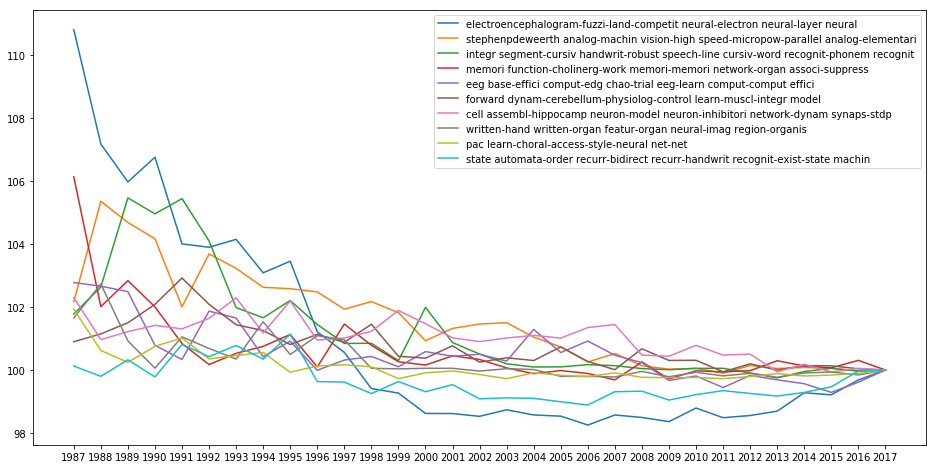

In [66]:
# plot bottom 10
fig,ax = plt.subplots()

for f in (bottom_10.columns):
    ax.plot(bottom_10.index.values, bottom_10[f], label=f)
    
ax.legend(loc='upper right', ncol=1)

In [67]:
n_words_per_topic = 6
for i in bi:
    topics = ", ".join(lsa_syn_dict[i][:n_words_per_topic])
    print("Topic {}: ".format(i), topics)

Topic 390:  electroencephalogram, fuzzi, land, competit neural, electron neural, layer neural
Topic 283:  stephenpdeweerth analog, machin vision, high speed, micropow, parallel analog, elementari
Topic 15:  integr segment, cursiv handwrit, robust speech, line cursiv, word recognit, phonem recognit
Topic 233:  memori function, cholinerg, work memori, memori network, organ associ, suppress
Topic 0:  eeg base, effici comput, edg chao, trial eeg, learn comput, comput effici
Topic 106:  forward dynam, cerebellum, physiolog, control learn, muscl, integr model
Topic 48:  cell assembl, hippocamp neuron, model neuron, inhibitori network, dynam synaps, stdp
Topic 49:  written, hand written, organ featur, organ neural, imag region, organis
Topic 127:  pac learn, choral, access, style, neural net, net
Topic 5:  state automata, order recurr, bidirect recurr, handwrit recognit, exist, state machin


It would appear our least trending topics are electro-neural, analog, and handwriting/speech recognition.

### <a class="anchor" id="a3">Full-text LSA topics</a>

This section is identical to "Trending LSA topics" but uses full body text instead of just titles.

In [68]:
# get all weighted one and two grams 
#full_tfidf = get_word_count(get_tfidf, full_strings)
full_tfidf = pd.read_pickle("full_tfidf.pkl")

# get all words in tf-idf corpus
all_words = full_tfidf.columns

# get word importance, including and excluding authors
word_importance = np.sum(full_tfidf, axis=0)
word_importance1 = [word_importance[word] if word not in authors_list1 else 999 for word in word_importance.index]

# get most important words
important_words = np.flip(np.argsort(word_importance).values, axis=0)

# build lsa model and extract relevant matrices
lsa_model = TruncatedSVD(n_components=100)
lsa_doc_matrix = lsa_model.fit_transform(full_tfidf)
lsa_term_matrix = lsa_model.components_
lsa_topic_matrix = np.diag(lsa_model.singular_values_)

# get counts of how many documents belong to each topic
lsa_keys = get_keys(lsa_doc_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

# generate dictionary mapping topic id to primary words
words_in_topic = get_words_for_topic(lsa_term_matrix, full_tfidf.columns)
topic_names = {}
for key, value in words_in_topic.items():
    topic_names[str(key)] = "-".join(value[:3])
    
# examine words within the top topics
n_top_topics = 10
n_words_per_topic = 5
top_topics = np.array(lsa_categories)[np.flip(np.argsort(lsa_counts), axis=0)]
for i in top_topics[:n_top_topics]:
    topics = ", ".join(words_in_topic[i][:n_words_per_topic])
    print("Topic {}: ".format(i), topics)

Topic 0:  experi, consid, learn, paramet, model
Topic 1:  neuron, neurosci, cortex, stimulus, cell
Topic 5:  morgan, perceptron, architectur, layer, backpropag
Topic 7:  graph, edg, node, howev graph, graphic
Topic 2:  deep, cvpr, dataset, convolut, bengio
Topic 48:  incomplet, root, phase, howev prefer, prefer alway
Topic 4:  bayesian, posterior, likelihood, markov, mixtur
Topic 29:  david, solid, michael, stage, speech
Topic 8:  network, node, connect, propag, languag


In [69]:
# get yearly aggregates
lsa_data = pd.DataFrame(lsa_doc_matrix)
lsa_data[lsa_data < 0] = 0
lsa_data["year"] = data["year"]
lsa_data = lsa_data.groupby(["year"]).agg(["sum"])
lsa_data.columns = [str(i) for i in list(range(100))]

# get top 10 and bottom 10 trends
top_10, bottom_10, ti, bi = get_top_bottom(lsa_data)
bottom_10 = bottom_10.rename(index=str, columns=topic_names)
top_10 = top_10.rename(index=str, columns=topic_names)

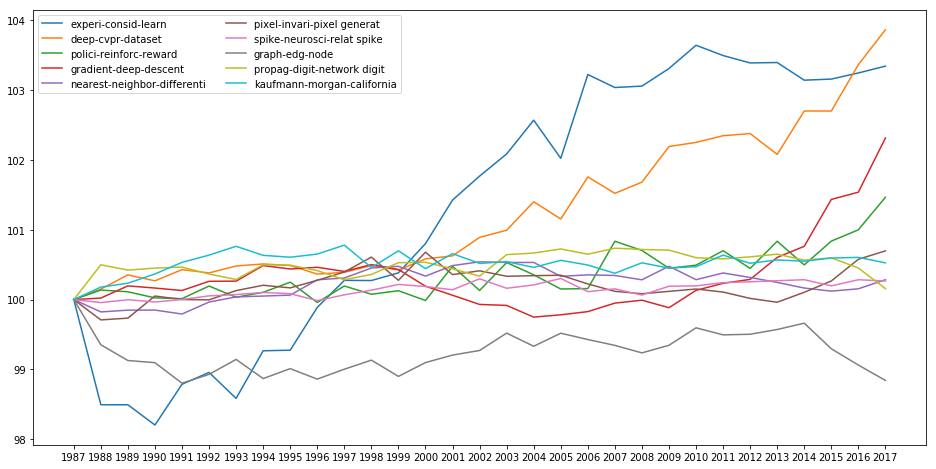

In [70]:
# plot top 10
fig,ax = plt.subplots()

for f in (top_10.columns):
    ax.plot(top_10.index.values, top_10[f], label=f)
    
ax.legend(loc='upper left', ncol=2)

In [71]:
n_words_per_topic = 8
for i in ti:
    topics = ", ".join(words_in_topic[i][:n_words_per_topic])
    print("Topic {}: ".format(i), topics)

Topic 0:  experi, consid, learn, paramet, model, mean, network, neural
Topic 2:  deep, cvpr, dataset, convolut, bengio, recognit, imag, iccv
Topic 3:  polici, reinforc, reward, action, agent, conclus polici, game, deci
Topic 6:  gradient, deep, descent, stochast, gradient assum, batch, arxiv, recurr
Topic 30:  nearest, neighbor, differenti, emb, store, euclidean, manifold, causal
Topic 9:  pixel, invari, pixel generat, vision, scene, rotat, convolut, hinton
Topic 24:  spike, neurosci, relat spike, threshold, potenti neuron, neurosci scienc, brain, neuron
Topic 7:  graph, edg, node, howev graph, graphic, markov, program, undirect
Topic 25:  propag, digit, network digit, weiss, digit support, belief, graph, spectral
Topic 35:  kaufmann, morgan, california, grant, thank, proceed morgan, kaufmann correspond, acknowledg


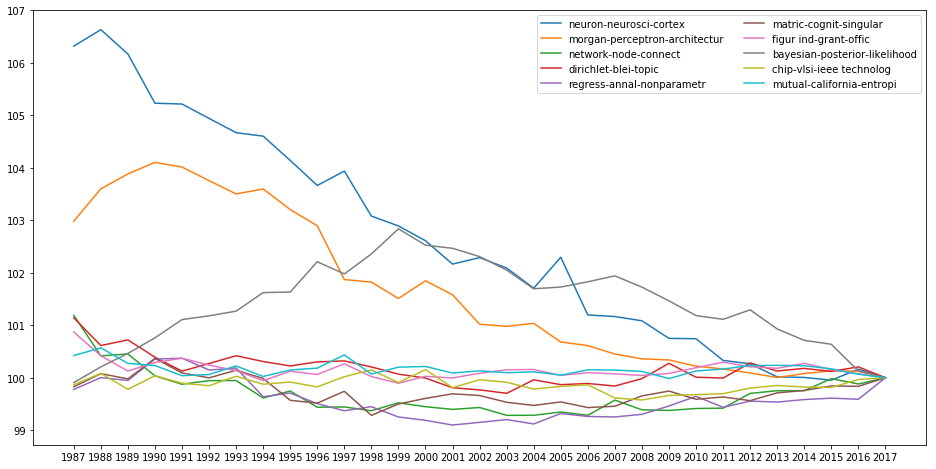

In [72]:
# plot bottom 10
fig,ax = plt.subplots()

for f in (bottom_10.columns):
    ax.plot(bottom_10.index.values, bottom_10[f], label=f)
    
ax.legend(loc='upper right', ncol=2)

In [73]:
n_words_per_topic = 8
for i in bi:
    topics = ", ".join(words_in_topic[i][:n_words_per_topic])
    print("Topic {}: ".format(i), topics)

Topic 1:  neuron, neurosci, cortex, stimulus, cell, synapt, respon, brain
Topic 5:  morgan, perceptron, architectur, layer, backpropag, kaufmann, recognit, net
Topic 8:  network, node, connect, propag, languag, circuit, layer, net
Topic 17:  dirichlet, blei, topic, alloc, cluster, approach blei, retriev, categori
Topic 14:  regress, annal, nonparametr, american, lasso, friedman, region, perform annal
Topic 10:  matric, cognit, singular, languag, connectionist, spectral, speech, subspac
Topic 51:  figur ind, grant, offic, john, thank, criterion, freedom, acknowledg
Topic 4:  bayesian, posterior, likelihood, markov, mixtur, mont, likelihood sinc, carlo
Topic 12:  chip, vlsi, ieee technolog, electr, speech, technolog, ieee, filter
Topic 52:  mutual, california, entropi, stage, carri, stage lower, california sinc, root


Unfortunately with full body text, the results were less interpretable. Furthermore, the model picked up sections in the text devoted to grants, acknowledgements, and thank yous, which further muddled our results.

## <a class="anchor" id="b">Latent Dirichlet Allocation</a>

The below shows our best results with the LDA. Note that we have also ran the LDA with author and titles, not just body text, as well as with and without normalization with TF-IDF.

### LDA grid search

Unlike LSA, LDA has two hyper-paramters, alpha and eta.

alpha corresponds to how many topics contribute to each document.

beta corresponds to how many words contribute to each topic.

To tune for these parameters, we will split our data into a training and testing set, then use cross-validation to seek out the lowest perplexity value.

In [74]:
# define search parameters
#search_params = {"topic_word_prior": [0.02, 0.05, 0.10, 0.20], "doc_topic_prior": [0.05, 0.10, 0.20]}

# initate lda model
#lda = LatentDirichletAllocation(n_components=50,
#                                learning_decay=0.5)

# initiate grid search
#model = GridSearchCV(lda, param_grid=search_params)

# do grid search
#model.fit(full_count)

In [75]:
# best model
#best_lda_model = model.best_estimator_

# model parameters
#print("Best Model's Params: ", model.best_params_)
#print("Best Log Likelihood Score: ", model.best_score_)
#print("Model Perplexity: ", best_lda_model.perplexity(full_count))

In [76]:
#Best Model's Params:  {'doc_topic_prior': 0.05, 'topic_word_prior': 0.2}
#Best Log Likelihood Score:  -540246.118202376
#Model Perplexity:  7089.936658033379

### LDA model

In [101]:
lda_model = LatentDirichletAllocation(n_components=50, 
                                      learning_method='online',
                                      random_state=0,
                                      doc_topic_prior=0.05,
                                      topic_word_prior=0.2)
lda_doc_matrix = lda_model.fit_transform(full_count)
lda_term_matrix = lda_model.components_

In [102]:
lda_keys = get_keys(lsa_doc_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [103]:
# generate dictionary mapping topic id to primary words
words_in_topic = get_words_for_topic(lsa_term_matrix, full_count.columns)
topic_names = {}
for key, value in words_in_topic.items():
    topic_names[str(key)] = "-".join(value[:3])

In [104]:
# examine words within the top topics
n_top_topics = 10
n_words_per_topic = 5
top_topics = np.array(lda_categories)[np.flip(np.argsort(lda_counts), axis=0)]
for i in top_topics[:n_top_topics]:
    topics = ", ".join(words_in_topic[i][:n_words_per_topic])
    print("Topic {}: ".format(i), topics)

Topic 0:  experi, consid, learn, paramet, model
Topic 1:  neuron, neurosci, cortex, stimulus, cell
Topic 5:  morgan, perceptron, architectur, layer, backpropag
Topic 7:  graph, edg, node, howev graph, graphic
Topic 2:  deep, cvpr, dataset, convolut, bengio
Topic 20:  arm, cesa, bianchi, bandit, regret
Topic 4:  bayesian, posterior, likelihood, markov, mixtur
Topic 36:  priori, bay, morgan, kaufmann, priori case
Topic 78:  environ, symmetr, quick set, describ quick, vertic


### Trending LDA topics

In [105]:
lda_data = pd.DataFrame(lda_doc_matrix)
lda_data[lda_data < 0] = 0
lda_data["year"] = data["year"]
lda_data = lda_data.groupby(["year"]).agg(["sum"])
lda_data.columns = [str(i) for i in list(range(50))]

In [106]:
# get top 10 and bottom 10 trends
top_10, bottom_10, ti, bi = get_top_bottom(lda_data)
bottom_10 = bottom_10.rename(index=str, columns=topic_names)
top_10 = top_10.rename(index=str, columns=topic_names)

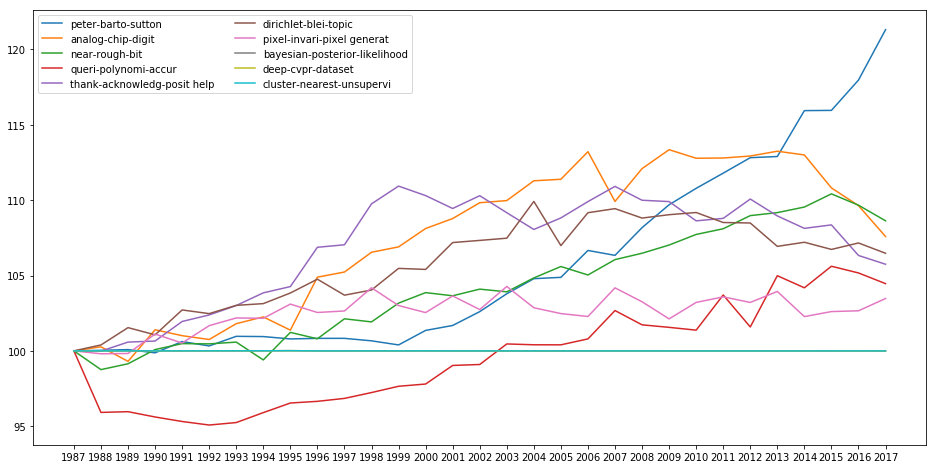

In [107]:
# plot top 10
fig,ax = plt.subplots()

for f in (top_10.columns):
    ax.plot(top_10.index.values, top_10[f], label=f)
    
ax.legend(loc='upper left', ncol=2)

In [108]:
n_words_per_topic = 8
for i in ti:
    topics = ", ".join(words_in_topic[i][:n_words_per_topic])
    print("Topic {}: ".format(i), topics)

Topic 41:  peter, barto, sutton, peter mean, reinforc, absolut, degr, logarithm
Topic 15:  analog, chip, digit, vlsi, dual, shwartz, shalev, conjug
Topic 11:  near, rough, bit, extrem, noi, quick, poor, fraction
Topic 23:  queri, polynomi, accur, network support, output learn, output, rank, california
Topic 48:  thank, acknowledg, posit help, help, grant, recent thank, help pattern, behavior acknowledg
Topic 17:  dirichlet, blei, topic, cluster, alloc, approach blei, retriev, categori
Topic 9:  pixel, invari, pixel generat, vision, scene, rotat, convolut, hinton
Topic 4:  bayesian, posterior, likelihood, markov, mixtur, mont, likelihood sinc, carlo
Topic 2:  deep, cvpr, dataset, convolut, bengio, recognit, imag, iccv
Topic 22:  cluster, nearest, unsupervi, mixtur, supervi, speech, manifold, unsupervi point


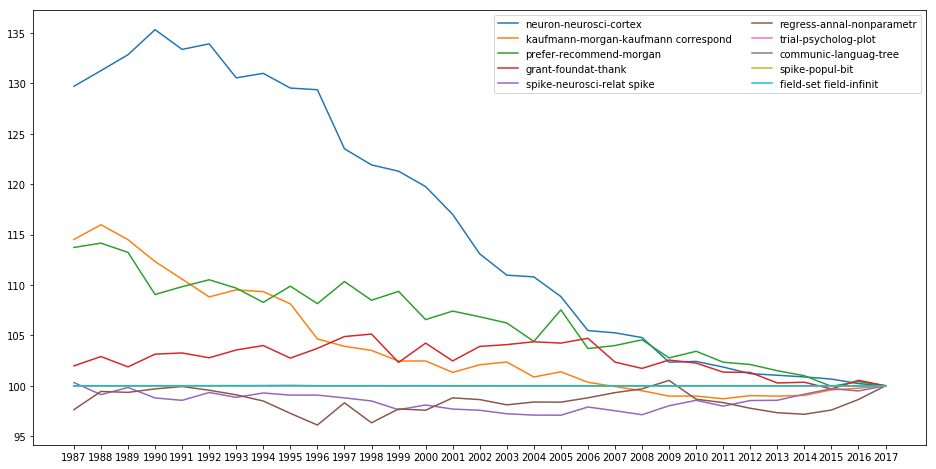

In [109]:
# plot bottom 10
fig,ax = plt.subplots()

for f in (bottom_10.columns):
    ax.plot(bottom_10.index.values, bottom_10[f], label=f)
    
ax.legend(loc='upper right', ncol=2)

In [110]:
n_words_per_topic = 8
for i in bi:
    topics = ", ".join(words_in_topic[i][:n_words_per_topic])
    print("Topic {}: ".format(i), topics)

Topic 1:  neuron, neurosci, cortex, stimulus, cell, synapt, respon, brain
Topic 43:  kaufmann, morgan, kaufmann correspond, propag, nearest, choo optim, amplitud, intellig choo
Topic 33:  prefer, recommend, morgan, social, filter, item, howev prefer, artifici
Topic 40:  grant, foundat, thank, acknowledg, foundat inform, determin foundat, nation, posit help
Topic 24:  spike, neurosci, relat spike, threshold, potenti neuron, neurosci scienc, brain, recognit
Topic 14:  regress, annal, nonparametr, american, lasso, friedman, region, perform annal
Topic 27:  trial, psycholog, plot, vertic, psycholog requir, vertic experi, plot combin, cognit
Topic 28:  communic, languag, tree, decod, solid, linguist, log problem, dash
Topic 29:  spike, popul, bit, relat spike, bin, trial, goal popul, code
Topic 30:  field, set field, infinit, program, thank, carlo, polynomi, field general


Because the LDA ran with the full body text, it had the same issue of LSA of picking up sections that were not meant to be picked up. Furthermore, through multiple runs of the LDA, we discovered the results were not particularly stable, with no interpretable meaning that we were able to parse out.

## <a class="anchor" id="c">Neural Nets with Word2Vec</a>

In our final topic modelling section, we explored the potential with Word2Vec. For this section, we will primarily use titles only and treat them as our sentences.

In [77]:
titles_sent = [custom_tokenize(title) for title in data["title"]]

In [78]:
word2vec = Word2Vec(titles_sent, 
                    size=20, 
                    window=5,
                    min_count=5, 
                    sg=0)
word2vec.train(titles_sent, total_examples=len(titles_sent), epochs=10)

(338957, 457770)

In [79]:
word_vectors = word2vec.wv
word_corpus = word2vec.wv.vocab 

In [80]:
print(u'{:,} terms in word2vec dictionary.'.format(len(word_corpus)))

1,187 terms in word2vec dictionary.


In [81]:
all_word_vecs = []
for word in word_corpus:
    all_word_vecs.append(word_vectors[word])

In [82]:
all_word_vecs = pd.DataFrame(all_word_vecs).transpose()
all_word_vecs.columns = word_corpus

### Word similarities and synonyms

As part of our exploration and test to see how well the neural nets performed, we manually went through a few of their gathered synonyms. From what we could tell, they proved quite successful.

In [83]:
def get_related_terms(token, topn=10):
    for word, similarity in word2vec.wv.most_similar(positive=[token], topn=topn):
        print(u'{:20} {}'.format(word, round(similarity, 3)))

def word_algebra(add=[], subtract=[], topn=10):
    answers = word2vec.wv.most_similar(positive=add, negative=subtract, topn=topn)
    for term, similarity in answers:
        print(term)

In [84]:
get_related_terms('neural')

recurr               0.98
convolut             0.94
implement            0.936
neuron               0.929
vlsi                 0.927
analog               0.921
net                  0.916
chip                 0.912
network              0.908
system               0.903


In [85]:
word_algebra(add=["neural", "eye"])

net
circuit
integr
artifici
architectur
chip
cortic
cell
cortex
connect


### Word mover distance

To determine document similarity, we then turned to WMD. Note that we will be importing the results straight from our previous run, since this took ~16 hours per run on 4 cores. Finally, we applied clustering of the documents.

In [86]:
#doc_distances = np.zeros((len(titles_sent),len(titles_sent)))
#for i in range(len(titles_sent)):
#    for j in range(i+1, len(titles_sent)):
#        doc_distances[i, j] = word_vectors.wmdistance(titles_sent[i], titles_sent[j])

In [87]:
#clustering = AgglomerativeClustering(n_clusters=100, affinity="precomputed", linkage="average")
#cluster_labels = clustering.fit_predict(doc_distances)

In [88]:
cluster_labels = pd.read_csv("cut100.txt", header=None)[0].values - 1

In [89]:
cluster_data = pd.DataFrame(data["year"].copy())
cluster_data["group"] = cluster_labels
cluster_data.columns = ["year", "group"]
cluster_data["ones"] = 1
cluster_data = cluster_data.groupby(["year", "group"]).agg("sum").reset_index()
cluster_data = cluster_data.pivot(index="year", columns="group", values="ones")
cluster_data[np.isnan(cluster_data)] = 0

In [90]:
titles_tfidf = get_word_count(get_tfidf, data["title"])

In [91]:
titles_tfidf_syn = titles_tfidf.copy()
titles_tfidf_syn["doc_type"] = cluster_labels
titles_tfidf_syn = titles_tfidf_syn.groupby("doc_type").agg("sum")

In [92]:
w2v_syn_dict = {}
for i in set(cluster_labels):
    row = titles_tfidf_syn.columns[np.flip(np.argsort(titles_tfidf_syn.loc[i, ]), axis=0)].values
    w2v_syn_dict[i] = row

In [93]:
w2v_syn_labels = {}
for i in set(cluster_labels):
    w2v_syn_labels[str(i)] = "-".join(w2v_syn_dict[i][:5])

### Trending document clusters

With the WMD, we have managed to cluster similar documents into groups. We will now map how these groups trend.

In [122]:
# get top 10 and bottom 10 trends
top_10, bottom_10, ti, bi = get_top_bottom(cluster_data)
top_10.columns = [str(v) for v in top_10.columns.values]
bottom_10.columns = [str(v) for v in bottom_10.columns.values]
bottom_10 = bottom_10.rename(index=str, columns=w2v_syn_labels)
top_10 = top_10.rename(index=str, columns=w2v_syn_labels)

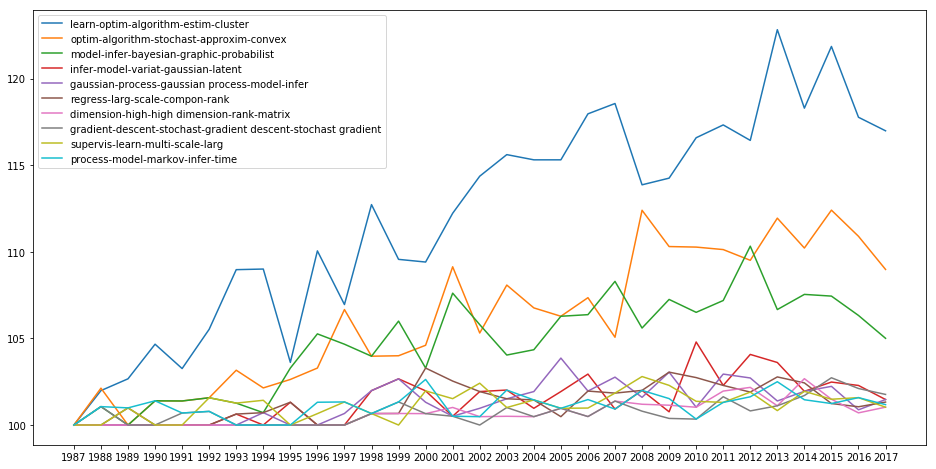

In [124]:
# plot top 10
fig,ax = plt.subplots()

for f in (top_10.columns):
    ax.plot(top_10.index.values, top_10[f], label=f)
    
ax.legend(loc='upper left', ncol=1)

In [128]:
n_words_per_topic = 6
for i in ti:
    topics = ", ".join(w2v_syn_dict[i][:n_words_per_topic])
    print("Doc group {}: ".format(i), topics)

Doc group 5:  learn, optim, algorithm, estim, cluster, kernel
Doc group 16:  optim, algorithm, stochast, approxim, convex, bound
Doc group 11:  model, infer, bayesian, graphic, probabilist, mixtur
Doc group 23:  infer, model, variat, gaussian, latent, process
Doc group 41:  gaussian, process, gaussian process, model, infer, variat
Doc group 4:  regress, larg, scale, compon, rank, compon analysi
Doc group 47:  dimension, high, high dimension, rank, matrix, reduct
Doc group 29:  gradient, descent, stochast, gradient descent, stochast gradient, polici
Doc group 36:  supervis, learn, multi, scale, larg, kernel
Doc group 26:  process, model, markov, infer, time, make


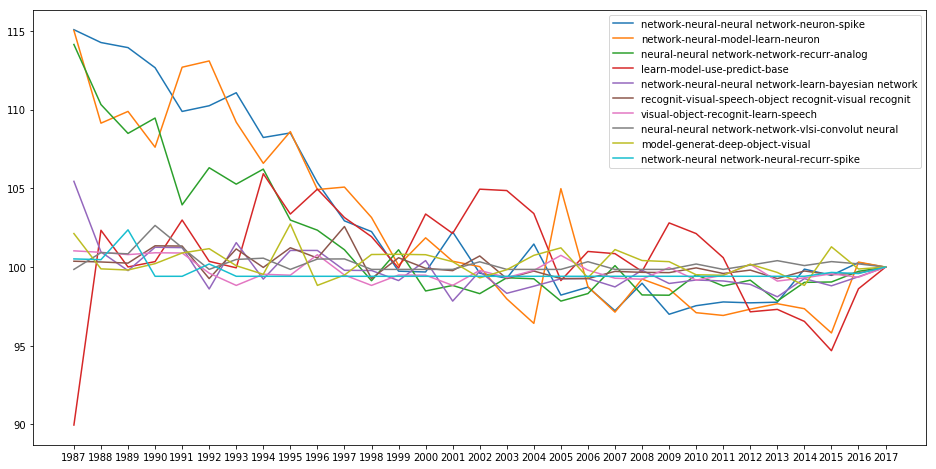

In [126]:
# plot bottom 10
fig,ax = plt.subplots()

for f in (bottom_10.columns):
    ax.plot(bottom_10.index.values, bottom_10[f], label=f)
    
ax.legend(loc='upper right', ncol=1)

In [129]:
n_words_per_topic = 6
for i in bi:
    topics = ", ".join(w2v_syn_dict[i][:n_words_per_topic])
    print("Doc group {}: ".format(i), topics)

Doc group 1:  network, neural, neural network, neuron, spike, recurr
Doc group 0:  network, neural, model, learn, neuron, use
Doc group 3:  neural, neural network, network, recurr, analog, vlsi
Doc group 2:  learn, model, use, predict, base, adapt
Doc group 12:  network, neural, neural network, learn, bayesian network, control
Doc group 8:  recognit, visual, speech, object recognit, visual recognit, object
Doc group 13:  visual, object, recognit, learn, speech, deep
Doc group 27:  neural, neural network, network, vlsi, convolut neural, recurr
Doc group 7:  model, generat, deep, object, visual, learn
Doc group 71:  network, neural network, neural, recurr, spike, analog


The results are very similar to our results from the LSA!

## <a class="anchor" id="six">Final trend analysis</a>

Our final trend analysis takes from our with within LSA. We plot below both the broad results as well as the fine. The methodology correspond to the first two subsections of the LSA chapter; please refer to it above!

In [157]:
# build lsa model and extract relevant matrices
lsa_model = TruncatedSVD(n_components=100)
lsa_doc_matrix = lsa_model.fit_transform(author_titles_tfidf)
lsa_term_matrix = lsa_model.components_
lsa_topic_matrix = np.diag(lsa_model.singular_values_)

# generate dictionary mapping topic id to primary words
words_in_topic = get_words_for_topic(lsa_term_matrix, author_titles_tfidf.columns)
topic_names = {}
for key, value in words_in_topic.items():
    topic_names[str(key)] = "-".join(value[:3])
    
# get lsa broad data
lsa_data_broad = pd.DataFrame(lsa_doc_matrix)
lsa_data_broad[lsa_data_broad < 0] = 0
lsa_data_broad["year"] = data["year"]
lsa_data_broad = lsa_data_broad.groupby(["year"]).agg(["sum"])
lsa_data_broad.columns = [str(i) for i in list(range(100))]

# get lsa fine data
lsa_data_fine = author_titles_tfidf_syn
lsa_data_fine[lsa_data_fine < 0] = 0
lsa_data_fine["year"] = data["year"]
lsa_data_fine = lsa_data_fine.groupby(["year"]).agg(["sum"])
lsa_data_fine.columns = [str(i) for i in range(lsa_data_fine.shape[1])]

### Past 30 years (broad)

In [158]:
# get top 10 and bottom 10 trends
top_10, bottom_10, ti, bi = get_top_bottom(lsa_data_broad)
bottom_10 = bottom_10.rename(index=str, columns=topic_names)
top_10 = top_10.rename(index=str, columns=topic_names)

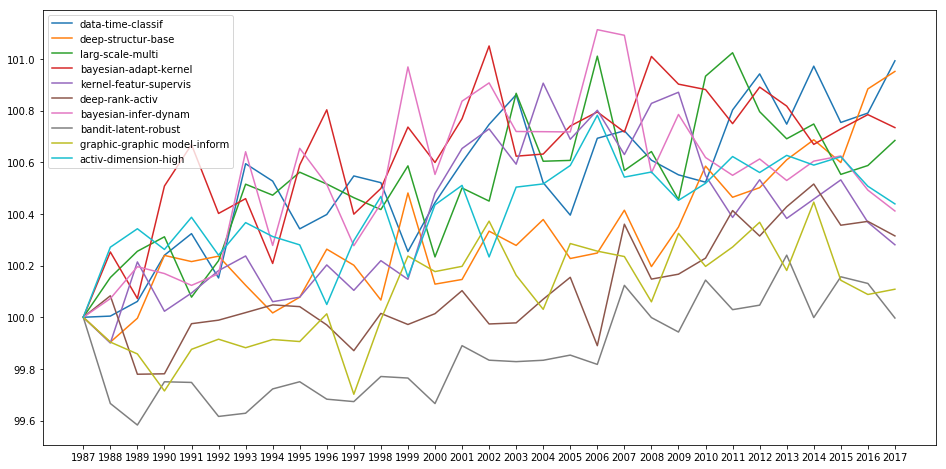

In [159]:
# plot top 10
fig,ax = plt.subplots()

for f in (top_10.columns):
    ax.plot(top_10.index.values, top_10[f], label=f)
    
ax.legend(loc='upper left', ncol=1)

In [160]:
n_words_per_topic = 6
for i in ti:
    topics = ", ".join(words_in_topic[i][:n_words_per_topic])
    print("Topic {}: ".format(i), topics)

Topic 30:  data, time, classif, deep, base, rank
Topic 21:  deep, structur, base, function, estim, adapt
Topic 14:  larg, scale, multi, larg scale, dynam, data
Topic 17:  bayesian, adapt, kernel, estim, multi, classif
Topic 23:  kernel, featur, supervis, select, semi, random
Topic 35:  deep, rank, activ, matrix, mont carlo, mont
Topic 8:  bayesian, infer, dynam, variat, neuron, spike
Topic 76:  bandit, latent, robust, variabl, discrimin, latent variabl
Topic 33:  graphic, graphic model, inform, random, dynam, spars
Topic 39:  activ, dimension, high, high dimension, field, activ learn


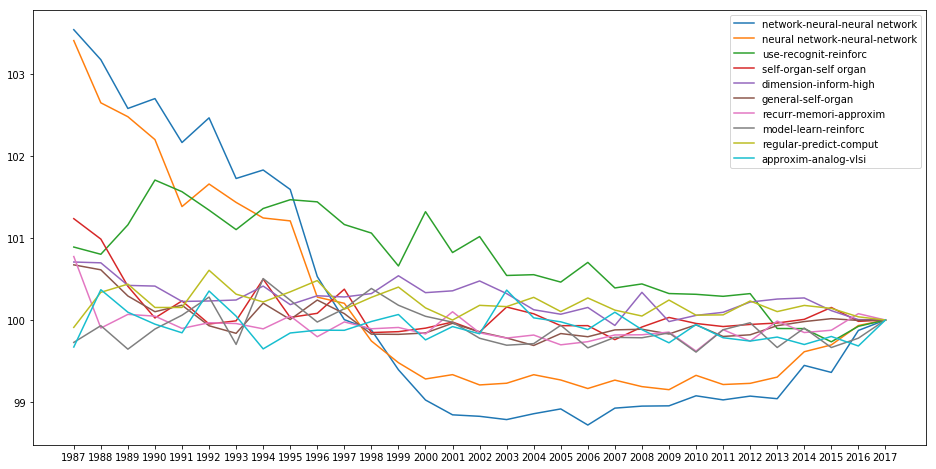

In [161]:
# plot bottom 10
fig,ax = plt.subplots()

for f in (bottom_10.columns):
    ax.plot(bottom_10.index.values, bottom_10[f], label=f)
    
ax.legend(loc='upper right', ncol=1)

In [162]:
n_words_per_topic = 6
for i in bi:
    topics = ", ".join(words_in_topic[i][:n_words_per_topic])
    print("Topic {}: ".format(i), topics)

Topic 0:  network, neural, neural network, learn, model, use
Topic 1:  neural network, neural, network, recurr, recurr neural, convolut neural
Topic 7:  use, recognit, reinforc, reinforc learn, dynam, neuron
Topic 48:  self, organ, self organ, map, predict, memori
Topic 43:  dimension, inform, high, classif, high dimension, mixtur
Topic 46:  general, self, organ, self organ, spars, mont carlo
Topic 63:  recurr, memori, approxim, stochast, associ, recurr neural
Topic 4:  model, learn, reinforc, reinforc learn, graphic, graphic model
Topic 50:  regular, predict, comput, local, graphic, graph
Topic 60:  approxim, analog, vlsi, detect, analog vlsi, onlin


### Past 30 years (fine)

In [163]:
# get top 10 and bottom 10 trends
top_10, bottom_10, ti, bi = get_top_bottom(lsa_data_fine)
bottom_10 = bottom_10.rename(index=str, columns=lsa_syn_labels)
top_10 = top_10.rename(index=str, columns=lsa_syn_labels)

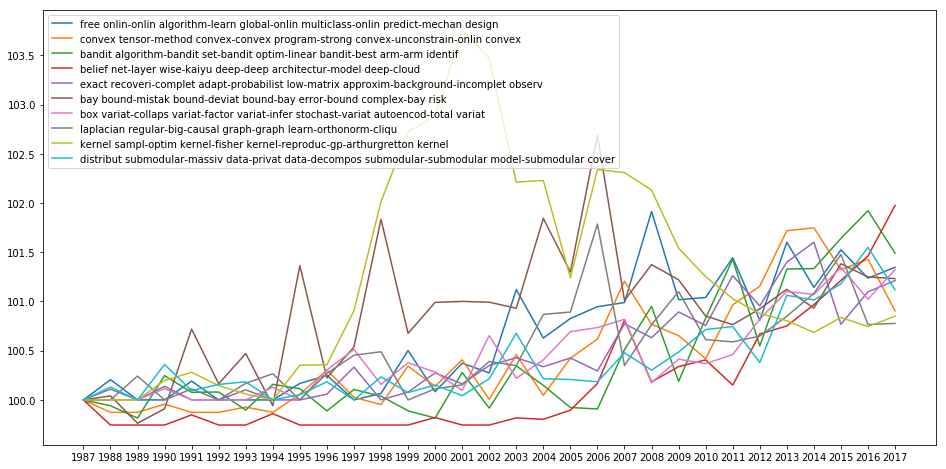

In [164]:
# plot top 10
fig,ax = plt.subplots()

for f in (top_10.columns):
    ax.plot(top_10.index.values, top_10[f], label=f)
    
ax.legend(loc='upper left', ncol=1)

In [165]:
n_words_per_topic = 6
for i in ti:
    topics = ", ".join(lsa_syn_dict[i][:n_words_per_topic])
    print("Topic {}: ".format(i), topics)

Topic 56:  free onlin, onlin algorithm, learn global, onlin multiclass, onlin predict, mechan design
Topic 8:  convex tensor, method convex, convex program, strong convex, unconstrain, onlin convex
Topic 93:  bandit algorithm, bandit set, bandit optim, linear bandit, best arm, arm identif
Topic 64:  belief net, layer wise, kaiyu deep, deep architectur, model deep, cloud
Topic 27:  exact recoveri, complet adapt, probabilist low, matrix approxim, background, incomplet observ
Topic 33:  bay bound, mistak bound, deviat bound, bay error, bound complex, bay risk
Topic 254:  box variat, collaps variat, factor variat, infer stochast, variat autoencod, total variat
Topic 232:  laplacian regular, big, causal graph, graph learn, orthonorm, cliqu
Topic 94:  kernel sampl, optim kernel, fisher kernel, reproduc, gp, arthurgretton kernel
Topic 144:  distribut submodular, massiv data, privat data, decompos submodular, submodular model, submodular cover


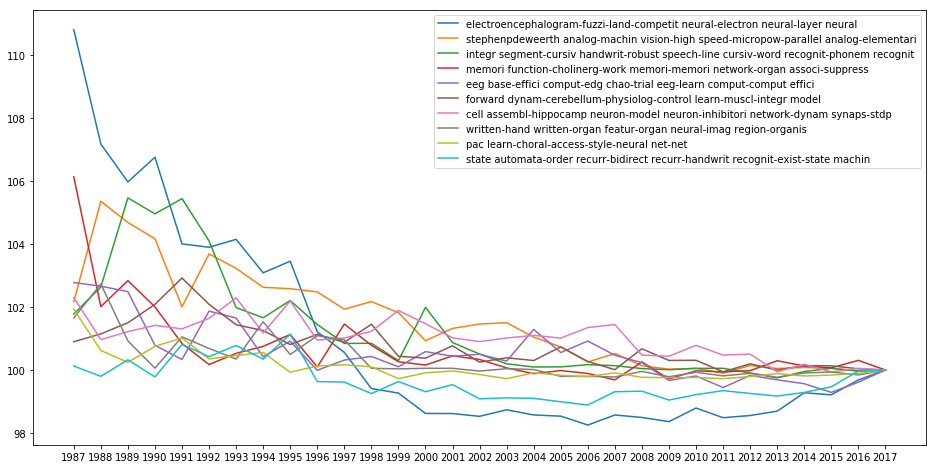

In [166]:
# plot bottom 10
fig,ax = plt.subplots()

for f in (bottom_10.columns):
    ax.plot(bottom_10.index.values, bottom_10[f], label=f)
    
ax.legend(loc='upper right', ncol=1)

In [167]:
n_words_per_topic = 6
for i in bi:
    topics = ", ".join(lsa_syn_dict[i][:n_words_per_topic])
    print("Topic {}: ".format(i), topics)

Topic 390:  electroencephalogram, fuzzi, land, competit neural, electron neural, layer neural
Topic 283:  stephenpdeweerth analog, machin vision, high speed, micropow, parallel analog, elementari
Topic 15:  integr segment, cursiv handwrit, robust speech, line cursiv, word recognit, phonem recognit
Topic 233:  memori function, cholinerg, work memori, memori network, organ associ, suppress
Topic 0:  eeg base, effici comput, edg chao, trial eeg, learn comput, comput effici
Topic 106:  forward dynam, cerebellum, physiolog, control learn, muscl, integr model
Topic 48:  cell assembl, hippocamp neuron, model neuron, inhibitori network, dynam synaps, stdp
Topic 49:  written, hand written, organ featur, organ neural, imag region, organis
Topic 127:  pac learn, choral, access, style, neural net, net
Topic 5:  state automata, order recurr, bidirect recurr, handwrit recognit, exist, state machin


### Past 10 years (broad)

In [168]:
# get top 10 and bottom 10 trends
top_10, bottom_10, ti, bi = get_top_bottom(lsa_data_broad.loc[list(range(2007,2018)), ])
bottom_10 = bottom_10.rename(index=str, columns=topic_names)
top_10 = top_10.rename(index=str, columns=topic_names)

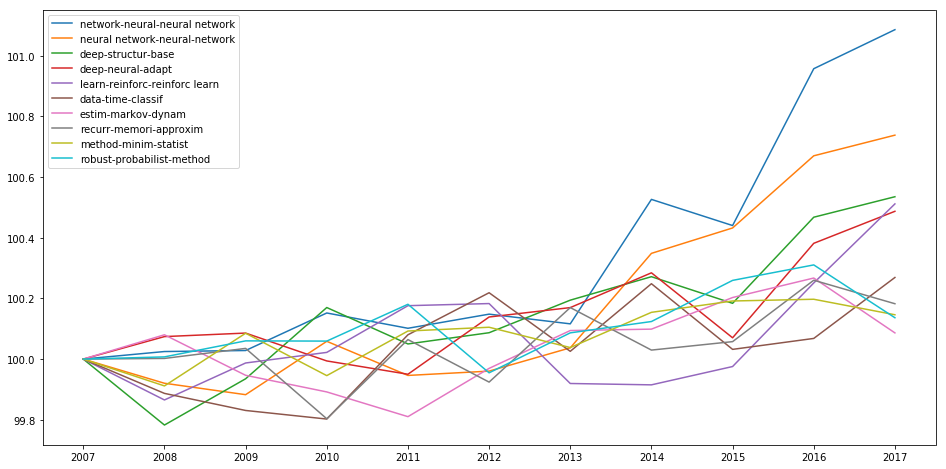

In [169]:
# plot top 10
fig,ax = plt.subplots()

for f in (top_10.columns):
    ax.plot(top_10.index.values, top_10[f], label=f)
    
ax.legend(loc='upper left', ncol=1)

In [170]:
n_words_per_topic = 6
for i in ti:
    topics = ", ".join(words_in_topic[i][:n_words_per_topic])
    print("Topic {}: ".format(i), topics)

Topic 0:  network, neural, neural network, learn, model, use
Topic 1:  neural network, neural, network, recurr, recurr neural, convolut neural
Topic 21:  deep, structur, base, function, estim, adapt
Topic 34:  deep, neural, adapt, predict, function, graph
Topic 2:  learn, reinforc, reinforc learn, deep, supervis, supervis learn
Topic 30:  data, time, classif, deep, base, rank
Topic 15:  estim, markov, dynam, use, supervis, random
Topic 63:  recurr, memori, approxim, stochast, associ, recurr neural
Topic 59:  method, minim, statist, convex, graph, fast
Topic 77:  robust, probabilist, method, represent, effici, order


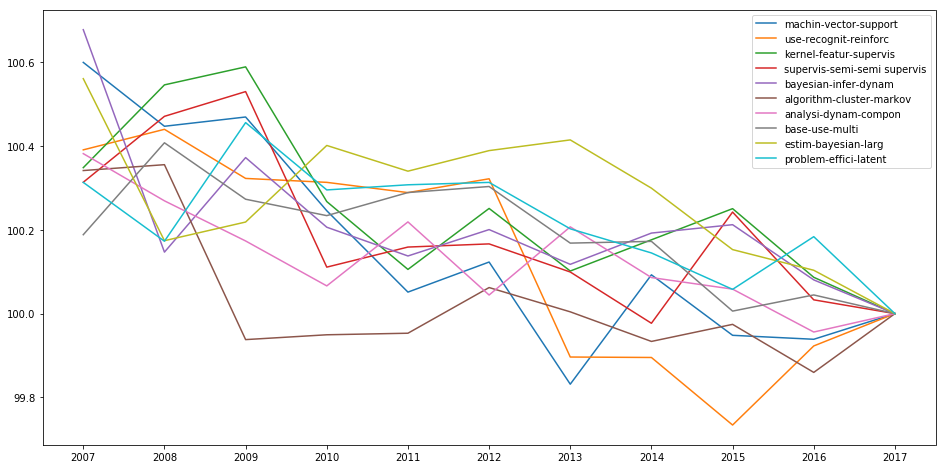

In [171]:
# plot bottom 10
fig,ax = plt.subplots()

for f in (bottom_10.columns):
    ax.plot(bottom_10.index.values, bottom_10[f], label=f)
    
ax.legend(loc='upper right', ncol=1)

In [172]:
n_words_per_topic = 6
for i in bi:
    topics = ", ".join(words_in_topic[i][:n_words_per_topic])
    print("Topic {}: ".format(i), topics)

Topic 5:  machin, vector, support, support vector, vector machin, kernel
Topic 7:  use, recognit, reinforc, reinforc learn, dynam, neuron
Topic 23:  kernel, featur, supervis, select, semi, random
Topic 22:  supervis, semi, semi supervis, adapt, supervis learn, classif
Topic 8:  bayesian, infer, dynam, variat, neuron, spike
Topic 11:  algorithm, cluster, markov, analysi, markov model, hidden
Topic 10:  analysi, dynam, compon, compon analysi, neuron, spike
Topic 29:  base, use, multi, activ, dynam, classif
Topic 16:  estim, bayesian, larg, markov, scale, activ
Topic 72:  problem, effici, latent, non, unsupervis, variabl


### Past 10 years (fine)

In [173]:
# get top 10 and bottom 10 trends
top_10, bottom_10, ti, bi = get_top_bottom(lsa_data_fine.loc[list(range(2007,2018)), ])
bottom_10 = bottom_10.rename(index=str, columns=lsa_syn_labels)
top_10 = top_10.rename(index=str, columns=lsa_syn_labels)

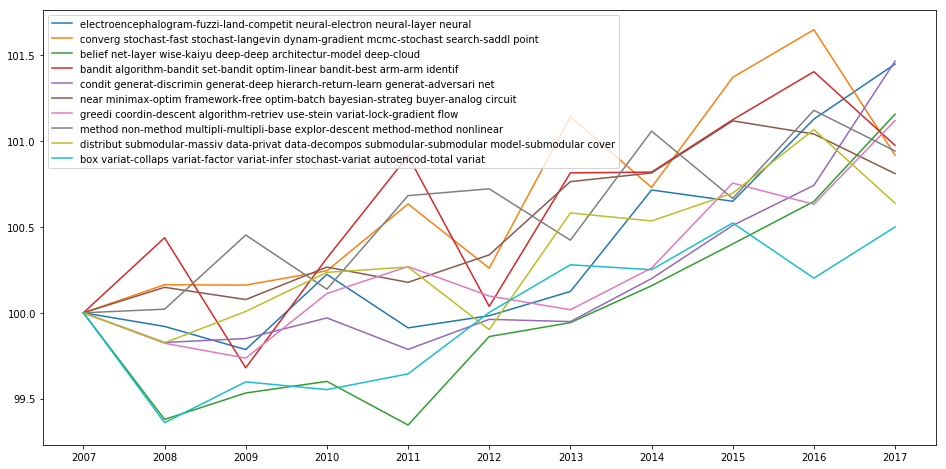

In [174]:
# plot top 10
fig,ax = plt.subplots()

for f in (top_10.columns):
    ax.plot(top_10.index.values, top_10[f], label=f)
    
ax.legend(loc='upper left', ncol=1)

In [175]:
n_words_per_topic = 6
for i in ti:
    topics = ", ".join(lsa_syn_dict[i][:n_words_per_topic])
    print("Topic {}: ".format(i), topics)

Topic 390:  electroencephalogram, fuzzi, land, competit neural, electron neural, layer neural
Topic 24:  converg stochast, fast stochast, langevin dynam, gradient mcmc, stochast search, saddl point
Topic 64:  belief net, layer wise, kaiyu deep, deep architectur, model deep, cloud
Topic 93:  bandit algorithm, bandit set, bandit optim, linear bandit, best arm, arm identif
Topic 54:  condit generat, discrimin generat, deep hierarch, return, learn generat, adversari net
Topic 46:  near minimax, optim framework, free optim, batch bayesian, strateg buyer, analog circuit
Topic 126:  greedi coordin, descent algorithm, retriev use, stein variat, lock, gradient flow
Topic 81:  method non, method multipli, multipli, base explor, descent method, method nonlinear
Topic 144:  distribut submodular, massiv data, privat data, decompos submodular, submodular model, submodular cover
Topic 254:  box variat, collaps variat, factor variat, infer stochast, variat autoencod, total variat


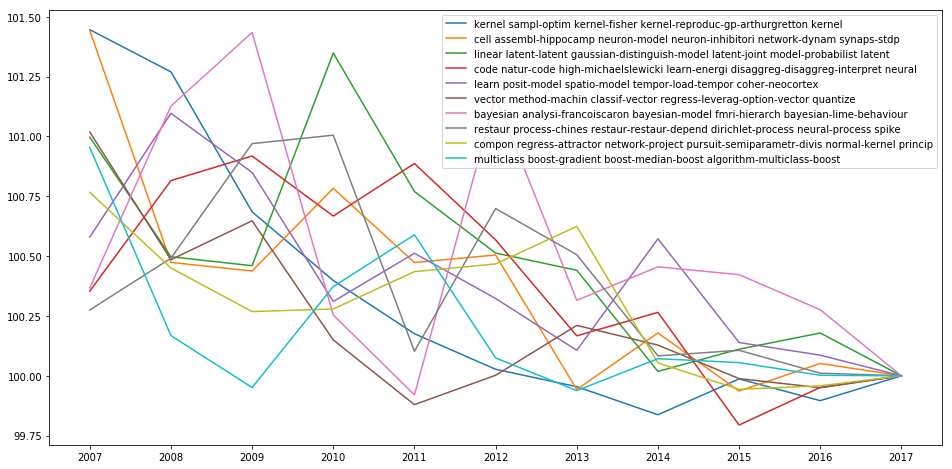

In [176]:
# plot bottom 10
fig,ax = plt.subplots()

for f in (bottom_10.columns):
    ax.plot(bottom_10.index.values, bottom_10[f], label=f)
    
ax.legend(loc='upper right', ncol=1)

In [177]:
n_words_per_topic = 6
for i in bi:
    topics = ", ".join(lsa_syn_dict[i][:n_words_per_topic])
    print("Topic {}: ".format(i), topics)

Topic 94:  kernel sampl, optim kernel, fisher kernel, reproduc, gp, arthurgretton kernel
Topic 48:  cell assembl, hippocamp neuron, model neuron, inhibitori network, dynam synaps, stdp
Topic 228:  linear latent, latent gaussian, distinguish, model latent, joint model, probabilist latent
Topic 118:  code natur, code high, michaelslewicki learn, energi disaggreg, disaggreg, interpret neural
Topic 150:  learn posit, model spatio, model tempor, load, tempor coher, neocortex
Topic 21:  vector method, machin classif, vector regress, leverag, option, vector quantize
Topic 204:  bayesian analysi, francoiscaron bayesian, model fmri, hierarch bayesian, lime, behaviour
Topic 13:  restaur process, chines restaur, restaur, depend dirichlet, process neural, process spike
Topic 202:  compon regress, attractor network, project pursuit, semiparametr, divis normal, kernel princip
Topic 195:  multiclass boost, gradient boost, median, boost algorithm, multiclass, boost


### Past 5 years (broad)

In [178]:
# get top 10 and bottom 10 trends
top_10, bottom_10, ti, bi = get_top_bottom(lsa_data_broad.loc[list(range(2012,2018)), ])
bottom_10 = bottom_10.rename(index=str, columns=topic_names)
top_10 = top_10.rename(index=str, columns=topic_names)

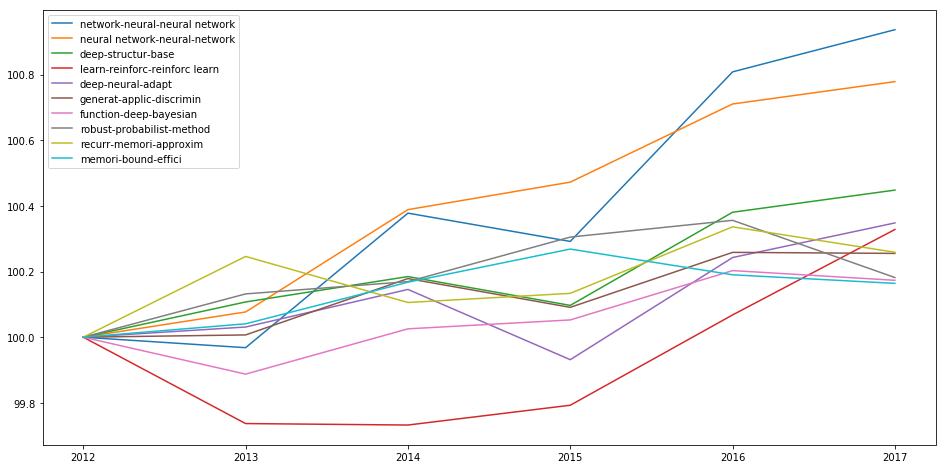

In [179]:
# plot top 10
fig,ax = plt.subplots()

for f in (top_10.columns):
    ax.plot(top_10.index.values, top_10[f], label=f)
    
ax.legend(loc='upper left', ncol=1)

In [180]:
n_words_per_topic = 6
for i in ti:
    topics = ", ".join(words_in_topic[i][:n_words_per_topic])
    print("Topic {}: ".format(i), topics)

Topic 0:  network, neural, neural network, learn, model, use
Topic 1:  neural network, neural, network, recurr, recurr neural, convolut neural
Topic 21:  deep, structur, base, function, estim, adapt
Topic 2:  learn, reinforc, reinforc learn, deep, supervis, supervis learn
Topic 34:  deep, neural, adapt, predict, function, graph
Topic 81:  generat, applic, discrimin, variat, space, neighbor
Topic 19:  function, deep, bayesian, use, imag, network
Topic 77:  robust, probabilist, method, represent, effici, order
Topic 63:  recurr, memori, approxim, stochast, associ, recurr neural
Topic 65:  memori, bound, effici, control, bandit, associ


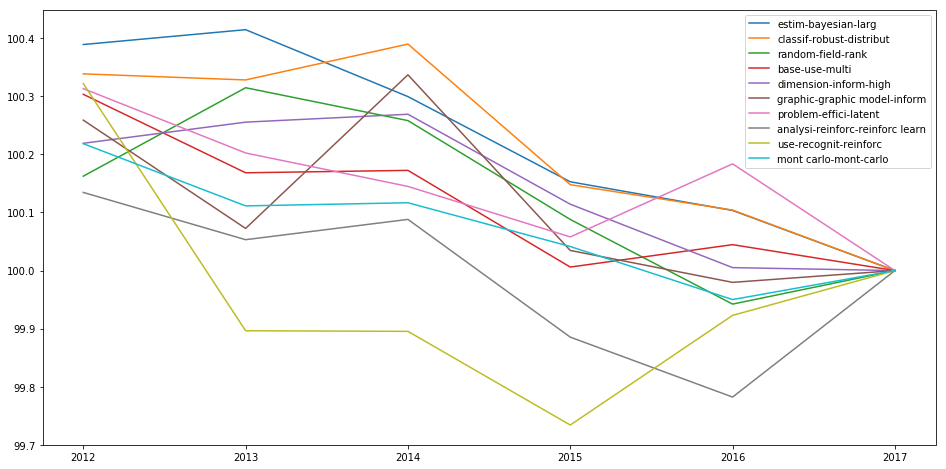

In [181]:
# plot bottom 10
fig,ax = plt.subplots()

for f in (bottom_10.columns):
    ax.plot(bottom_10.index.values, bottom_10[f], label=f)
    
ax.legend(loc='upper right', ncol=1)

In [182]:
n_words_per_topic = 6
for i in bi:
    topics = ", ".join(words_in_topic[i][:n_words_per_topic])
    print("Topic {}: ".format(i), topics)

Topic 16:  estim, bayesian, larg, markov, scale, activ
Topic 37:  classif, robust, distribut, regress, detect, graphic
Topic 38:  random, field, rank, comput, distribut, matrix
Topic 29:  base, use, multi, activ, dynam, classif
Topic 43:  dimension, inform, high, classif, high dimension, mixtur
Topic 33:  graphic, graphic model, inform, random, dynam, spars
Topic 72:  problem, effici, latent, non, unsupervis, variabl
Topic 9:  analysi, reinforc, reinforc learn, estim, compon, compon analysi
Topic 7:  use, recognit, reinforc, reinforc learn, dynam, neuron
Topic 32:  mont carlo, mont, carlo, function, algorithm, represent


### Past 5 years (fine)

In [183]:
# get top 10 and bottom 10 trends
top_10, bottom_10, ti, bi = get_top_bottom(lsa_data_fine.loc[list(range(2012,2018)), ])
bottom_10 = bottom_10.rename(index=str, columns=lsa_syn_labels)
top_10 = top_10.rename(index=str, columns=lsa_syn_labels)

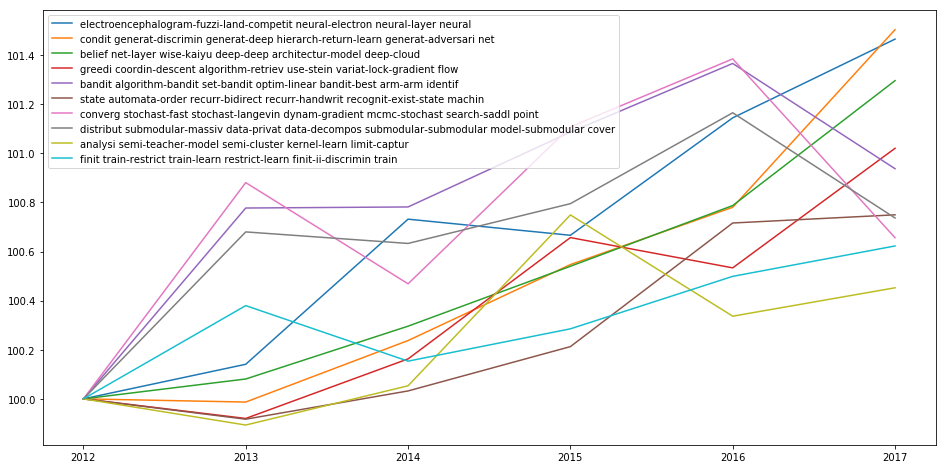

In [184]:
# plot top 10
fig,ax = plt.subplots()

for f in (top_10.columns):
    ax.plot(top_10.index.values, top_10[f], label=f)
    
ax.legend(loc='upper left', ncol=1)

In [185]:
n_words_per_topic = 6
for i in ti:
    topics = ", ".join(lsa_syn_dict[i][:n_words_per_topic])
    print("Topic {}: ".format(i), topics)

Topic 390:  electroencephalogram, fuzzi, land, competit neural, electron neural, layer neural
Topic 54:  condit generat, discrimin generat, deep hierarch, return, learn generat, adversari net
Topic 64:  belief net, layer wise, kaiyu deep, deep architectur, model deep, cloud
Topic 126:  greedi coordin, descent algorithm, retriev use, stein variat, lock, gradient flow
Topic 93:  bandit algorithm, bandit set, bandit optim, linear bandit, best arm, arm identif
Topic 5:  state automata, order recurr, bidirect recurr, handwrit recognit, exist, state machin
Topic 24:  converg stochast, fast stochast, langevin dynam, gradient mcmc, stochast search, saddl point
Topic 144:  distribut submodular, massiv data, privat data, decompos submodular, submodular model, submodular cover
Topic 23:  analysi semi, teacher, model semi, cluster kernel, learn limit, captur
Topic 9:  finit train, restrict train, learn restrict, learn finit, ii, discrimin train


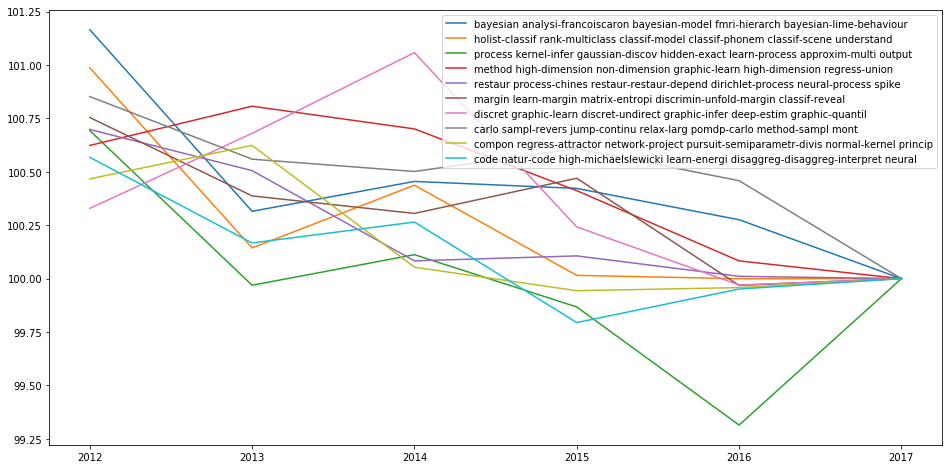

In [186]:
# plot bottom 10
fig,ax = plt.subplots()

for f in (bottom_10.columns):
    ax.plot(bottom_10.index.values, bottom_10[f], label=f)
    
ax.legend(loc='upper right', ncol=1)

In [187]:
n_words_per_topic = 6
for i in bi:
    topics = ", ".join(lsa_syn_dict[i][:n_words_per_topic])
    print("Topic {}: ".format(i), topics)

Topic 204:  bayesian analysi, francoiscaron bayesian, model fmri, hierarch bayesian, lime, behaviour
Topic 193:  holist, classif rank, multiclass classif, model classif, phonem classif, scene understand
Topic 65:  process kernel, infer gaussian, discov hidden, exact learn, process approxim, multi output
Topic 110:  method high, dimension non, dimension graphic, learn high, dimension regress, union
Topic 13:  restaur process, chines restaur, restaur, depend dirichlet, process neural, process spike
Topic 373:  margin learn, margin matrix, entropi discrimin, unfold, margin classif, reveal
Topic 99:  discret graphic, learn discret, undirect graphic, infer deep, estim graphic, quantil
Topic 37:  carlo sampl, revers jump, continu relax, larg pomdp, carlo method, sampl mont
Topic 202:  compon regress, attractor network, project pursuit, semiparametr, divis normal, kernel princip
Topic 118:  code natur, code high, michaelslewicki learn, energi disaggreg, disaggreg, interpret neural
